In [3]:
import pandas as pd
import shap
import xgboost
from catboost import CatBoostClassifier

pd.set_option( "display.max_columns", None)

In [4]:
df=pd.read_csv("telco_churn_prob/Telco_customer_churn.csv")
df

,CustomerID,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,CLTV,Churn Reason
0,3668-QPYBK,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,3239,Competitor made better offer
1,9237-HQITU,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,2701,Moved
2,9305-CDSKC,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,5372,Moved
3,7892-POOKP,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,5003,Moved
4,0280-XJGEX,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,5340,Competitor had better devices
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,No,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No,5306,NaN
7039,6840-RESVB,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No,2140,NaN
7040,2234-XADUH,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No,5560,NaN
7041,4801-JZAZL,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,2793,NaN


In [71]:
df_test=df.copy()
df_test=df_test.drop("Churn Label",axis=1)
df_test.to_csv("ex_test.csv")

In [72]:
df.value_counts("State")

State
California    7043
Name: count, dtype: int64

In [73]:
df.isna().sum()

CustomerID              0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
CLTV                    0
Churn Reason         5174
dtype: int64

In [74]:
df=df.drop(["Lat Long","CustomerID","Churn Reason", "Zip Code","Country","State"],axis=1)

In [75]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

num_cols=list(df.select_dtypes(exclude='object'))
 
df[num_cols] = std_scaler.fit_transform(df[num_cols])

In [76]:
df

,City,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,CLTV
0,Los Angeles,-0.944111,0.707268,Male,No,No,No,-1.236724,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,-0.362660,108.15,Yes,-0.981675
1,Los Angeles,-0.905362,0.691215,Female,No,No,Yes,-1.236724,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,0.197365,151.65,Yes,-1.436462
2,Los Angeles,-0.909951,0.697457,Female,No,No,Yes,-0.992402,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1.159546,820.5,Yes,0.821409
3,Los Angeles,-0.904204,0.687374,Female,No,Yes,Yes,-0.177995,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,1.330711,3046.05,Yes,0.509483
4,Los Angeles,-0.913530,0.710276,Male,No,No,Yes,0.677133,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),1.294151,5036.3,Yes,0.794358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Landers,-0.790334,1.510595,Female,No,No,No,1.613701,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),-1.449476,1419.4,No,0.765617
7039,Adelanto,-0.657542,1.048644,Male,No,Yes,Yes,-0.340876,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,0.665992,1990.5,No,-1.910691
7040,Amboy,-0.701497,1.928742,Female,No,Yes,Yes,1.613701,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),1.277533,7362.9,No,0.980330
7041,Angelus Oaks,-0.861169,1.360014,Female,No,Yes,Yes,-0.870241,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,-1.168632,346.45,No,-1.358692


In [77]:
X=df.drop("Churn Label",axis=1)
y=df['Churn Label']

In [78]:
cat_cols=list(X.select_dtypes("object"))
cat_cols

['City',
 'Gender',
 'Senior Citizen',
 'Partner',
 'Dependents',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Online Security',
 'Online Backup',
 'Device Protection',
 'Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Contract',
 'Paperless Billing',
 'Payment Method',
 'Total Charges']

In [79]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

In [80]:
#param_grid = {
#    'iterations': [300, 500],
#    'learning_rate': [0.01, 0.1],
#    'depth': [4, 6, 8],
#    'l2_leaf_reg': [1, 3, 5]
#}

param_grid = {
    'iterations': [300],
    'learning_rate': [0.1],
    'depth': [6, 8]
}

model = CatBoostClassifier(
    eval_metric='AUC',
    random_seed=40,
    verbose=False,  # Turn off verbosity for grid search
    cat_features=cat_cols
)

In [81]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,  # Use all available cores
    verbose=2
)

grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[CV] END .........depth=6, iterations=300, learning_rate=0.1; total time=  10.0s
[CV] END .........depth=6, iterations=300, learning_rate=0.1; total time=  10.2s
[CV] END .........depth=6, iterations=300, learning_rate=0.1; total time=  10.0s
[CV] END .........depth=6, iterations=300, learning_rate=0.1; total time=  11.2s
[CV] END .........depth=6, iterations=300, learning_rate=0.1; total time=  11.4s
[CV] END .........depth=8, iterations=300, learning_rate=0.1; total time=  20.8s
[CV] END .........depth=8, iterations=300, learning_rate=0.1; total time=  21.3s
[CV] END .........depth=8, iterations=300, learning_rate=0.1; total time=  21.0s
[CV] END .........depth=8, iterations=300, learning_rate=0.1; total time=  15.3s
[CV] END .........depth=8, iterations=300, learning_rate=0.1; total time=   7.6s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x70ce89bb41d0>,
             n_jobs=-1,
             param_grid={'depth': [6, 8], 'iterations': [300],
                         'learning_rate': [0.1]},
             scoring='roc_auc', verbose=2)

In [82]:
best_model=grid_search.best_estimator_

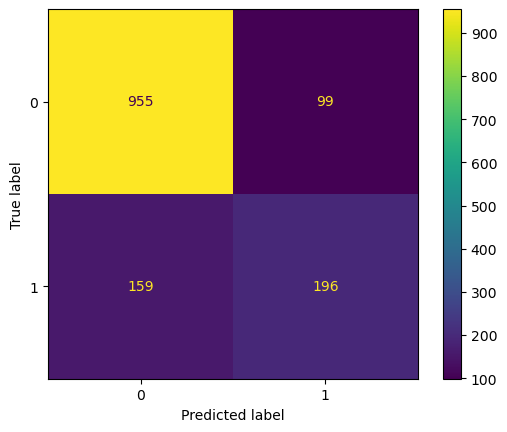

In [83]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

confusion_matrix=confusion_matrix(y_test, best_model.predict(X_test))

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show() 

In [84]:
grid_search.best_estimator_

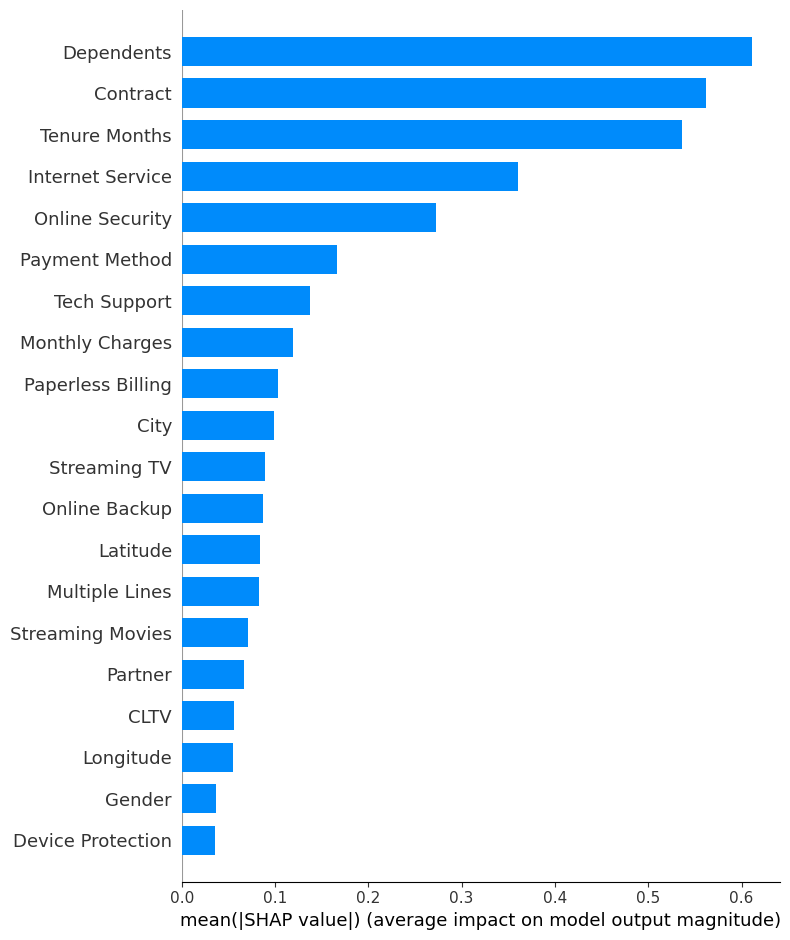

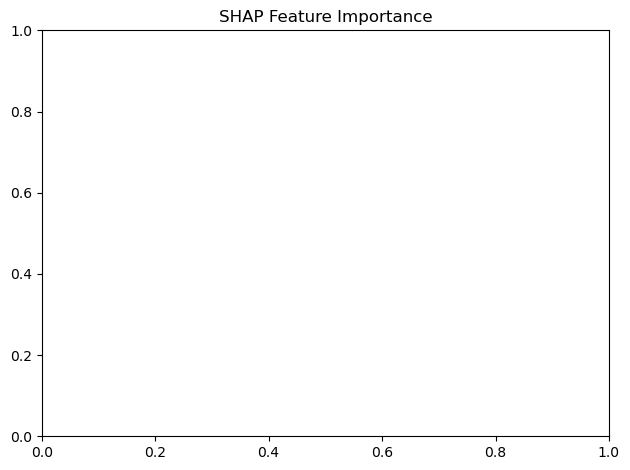

In [85]:
explainer = shap.TreeExplainer(best_model)
# Take first 1000 samples for computation efficiency
shap_values = explainer.shap_values(X_test.iloc[:1000])

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test.iloc[:1000], plot_type="bar")
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

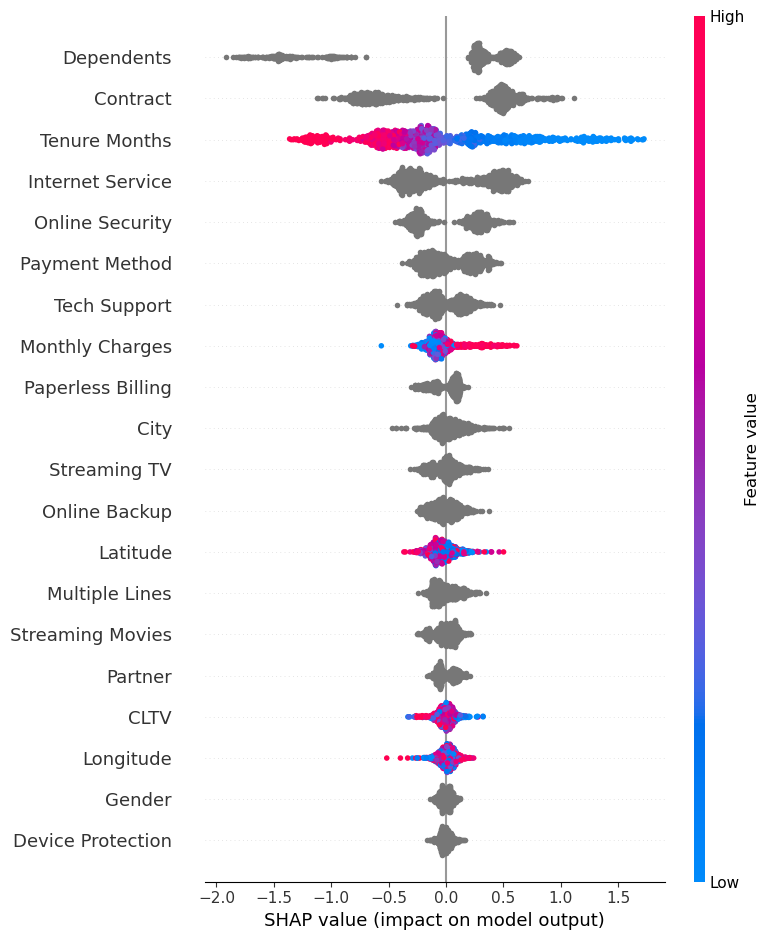

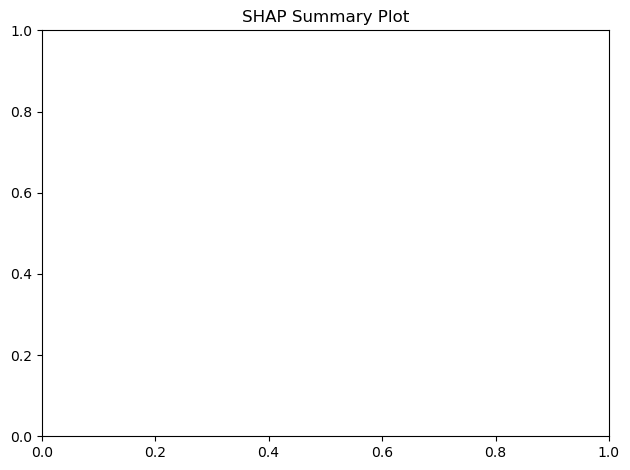

In [86]:
# Detailed summary plot with feature values
plt.figure(figsize=(10, 12))
shap.summary_plot(shap_values, X_test.iloc[:1000])
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

numeric_features=list(X.select_dtypes(exclude='object'))
categorical_features=list(X.select_dtypes(include='object'))

pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numeric_features),
            ('cat', SimpleImputer(strategy='mode', fill_value='missing'), 
             categorical_features)
        ],
        remainder='drop'  # This will drop any column not specified in the transformers
    )),
    ('classifier', CatBoostClassifier(
        iterations=300,
        learning_rate=0.1,
        depth=6,
        verbose=100,
        cat_features=list(range(len(numeric_features), 
                              len(numeric_features) + len(categorical_features)))
    ))
])

In [88]:
pipeline.fit(X_train,y_train)

0:	learn: 0.6378735	total: 20ms	remaining: 5.99s
100:	learn: 0.3538992	total: 1.14s	remaining: 2.25s
200:	learn: 0.3069362	total: 2.23s	remaining: 1.1s
299:	learn: 0.2710059	total: 3.33s	remaining: 0us


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Latitude', 'Longitude',
                                                   'Tenure Months',
                                                   'Monthly Charges', 'CLTV']),
                                                 ('cat',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant'),
                                                  ['City', 'Gender',
                                                   'Senior Citizen', 'Partner',
                                                   'Dependents',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'Paperless Billing',
                                                   'Payment Method',
                                                   'Total Charges'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x70ce9ed35640>)])

In [89]:
pipeline.predict(X_test)

array(['No', 'Yes', 'No', ..., 'Yes', 'No', 'No'], dtype=object)

In [90]:
import joblib

joblib.dump(pipeline,"pipe.pkl")

['pipe.pkl']